In [193]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from matplotlib.patches import Patch

In [194]:
# Define some lists we will use later
violent_crime = [
    'AGG ROBBERY/DEADLY WEAPON',
    'ROBBERY BY ASSAULT',
    'AGG ASLT W/MOTOR VEH FAM/DAT V',
    'AGG ASLT STRANGLE/SUFFOCATE',
    'AGG ASSAULT',
    'AGG ASLT ENHANC STRANGL/SUFFOC',
    'RAPE',
    'DEADLY CONDUCT',
    'AGG ASSAULT FAM/DATE VIOLENCE',
    'AGG RAPE OF A CHILD',
    'AGG RAPE',
    'ROBBERY BY THREAT',
    'AGG ROBBERY BY ASSAULT',
    'RAPE OF A CHILD',
    'AGG ASSAULT WITH MOTOR VEH',
    'MURDER',
    'AGG ASSAULT ON PUBLIC SERVANT',
    'DEADLY CONDUCT FAM/DATE VIOL',
    'MANSLAUGHTER'
]

In [195]:
# Import datasets
austin_crime = pd.read_csv('data/crime-housing-austin-2015.csv')
austin_weather = pd.read_csv('data/austin_weather.csv')
population_data = pd.read_csv('data/AustinZipCodes.csv')

percentage_columns = [
    'Populationbelowpovertylevel', 'Non-WhiteNon-HispanicorLatino', 
    'HispanicorLatinoofanyrace', 'Populationwithdisability', 'Unemployment',
    'Largehouseholds(5+members)', 'Homesaffordabletopeopleearninglessthan$50000',
    'Rentalsaffordabletopeopleearninglessthan$25000', 'Rent-restrictedunits',
    'HousingChoiceVoucherholders', 'Percentageofrentalunitsinpoorcondition',
    'Percentchangeinnumberofhousingunits2000-2012',
    'Changeinpercentageofpopulationbelowpoverty2000-2012',
    'Changeinmedianrent2000-2012', 'Changeinmedianhomevalue2000-2012',
    'Percentageofhomeswithin1/4-mioftransitstop',
    'Percentageofhousingandtransportationcoststhatistransportation-related'
]

currency_columns = ['Medianhouseholdincome', 'Medianrent', 'Medianhomevalue', 'Averagemonthlytransportationcost']

# Setup some functions to convert percentages and currency to floats
def percentage_to_float(value):
    try:
        return float(value.strip('%')) / 100
    except:
        return value

def currency_to_float(value):
    try:
        return float(value.replace('$', '').replace(',', ''))
    except:
        return value
    
# Process data for analysis
for col in percentage_columns:
    austin_crime[col] = austin_crime[col].apply(percentage_to_float)

for col in currency_columns:
    austin_crime[col] = austin_crime[col].apply(currency_to_float)

In [196]:
# Merge crime and weather data, get a daily high and low temperature for each crime
high_low_temp = austin_weather.groupby('Date').agg({'TempHighF': 'max', 'TempLowF': 'min'}).reset_index()

# Convert the date to a datetime object, for high_low_temp and austin_crime
high_low_temp['Date'] = pd.to_datetime(high_low_temp['Date'])
austin_crime['Report_Date'] = pd.to_datetime(austin_crime['Report_Date'])

# Merge the two dataframes
austin_crime = austin_crime.merge(high_low_temp, left_on='Report_Date', right_on='Date')

/tmp/ipykernel_1194494/2058581474.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  austin_crime['Report_Date'] = pd.to_datetime(austin_crime['Report_Date'])


In [197]:
# Filter the merged data for crime, date, and high and low temperature
crime_temp = austin_crime[['Highest_Offense_Desc', 'Zip_Code_Crime', 'Report_Date', 'TempHighF', 'TempLowF', 'Populationbelowpovertylevel']]

In [198]:
# Get a list of zip code for areas with more than 20% of population below the poverty level
poverty = austin_crime[austin_crime['Populationbelowpovertylevel'] > 0.2].dropna()
poverty_zips = poverty['Zip_Code_Crime'].unique()

In [199]:
# With the new poverty zips, add a column boolean for poverty_zip
crime_temp['Poverty_Zip'] = crime_temp['Zip_Code_Crime'].apply(lambda x: x in poverty['Zip_Code_Crime'].unique())

/tmp/ipykernel_1194494/4106168296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_temp['Poverty_Zip'] = crime_temp['Zip_Code_Crime'].apply(lambda x: x in poverty['Zip_Code_Crime'].unique())


/tmp/ipykernel_1194494/4029072734.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


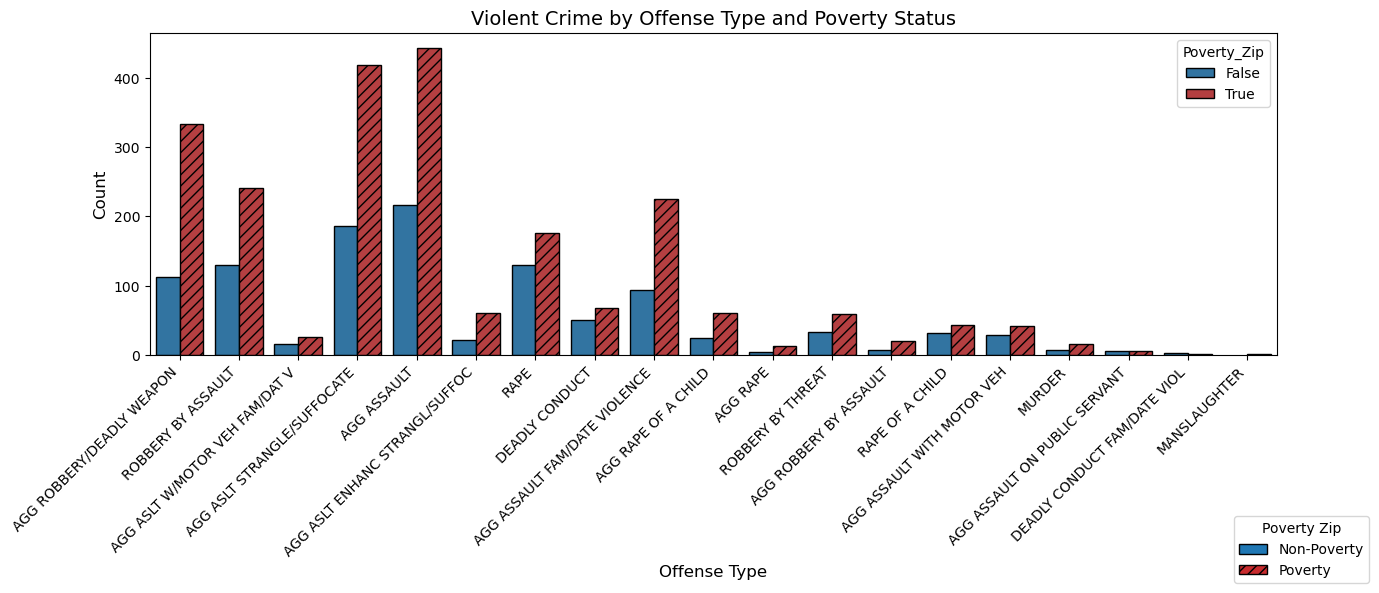

In [200]:
# Aggregate the Highest_Offense_Desc by poverty zip, compare crime in poverty zips by non-poverty zips
crime_poverty = crime_temp.groupby('Poverty_Zip')['Highest_Offense_Desc'].value_counts()

just_v_crime = crime_temp[crime_temp['Highest_Offense_Desc'].isin(violent_crime)]

# Create the countplot
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Highest_Offense_Desc', hue='Poverty_Zip', data=just_v_crime,
                   hue_order=[False, True],
                   palette=['#1f77b4', '#c82b2e'],
                   edgecolor='black')

# Apply hatch pattern to all poverty bars
n_bars = len(ax.patches) // 2
for i in range(n_bars - 1, len(ax.patches)):
    ax.patches[i].set_hatch('///')

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Offense Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Violent Crime by Offense Type and Poverty Status', fontsize=14)

# Setup legend
legend_elements = [Patch(facecolor='#1f77b4', edgecolor='black', label='Non-Poverty'),
                   Patch(facecolor='#c82b2e', edgecolor='black', hatch='///', label='Poverty')]

# Create a new axes for the legend
legend_ax = plt.axes([0.95, 0.05, 0.05, 0.05], frameon=False)
legend_ax.axis('off')

# Create the legend in the new axes
legend = legend_ax.legend(handles=legend_elements, title='Poverty Zip', loc='center left')

# Adjust the figure size to make room for the legend
plt.gcf().set_size_inches(13, 6)  # Increase the width slightly

plt.tight_layout()

plt.savefig('plots/violent_crime_by_poverty_status.png')
plt.show()

In [201]:
def population_adjusted(crime_data, population_data, crime_column, poverty_column, zip_column, save_plot=False, path='plots/population_adjusted_violent_crime_rates.png'):
    # Prepare population data
    pop_df = population_data.set_index('Zip Code')
    pop_df['Population'] = pd.to_numeric(pop_df['Population'].astype(str).str.replace(',', ''), errors='coerce')
    
    # Merge crime data with population data
    merged_data = crime_data.merge(pop_df[['Population']], left_on=zip_column, right_index=True, how='left')
    
    # Calculate crime rates per 1000 people
    crime_counts = merged_data.groupby([poverty_column, zip_column, crime_column]).size().reset_index(name='Count')
    crime_rates = crime_counts.merge(merged_data.groupby([poverty_column, zip_column])['Population'].first().reset_index(), 
                                     on=[poverty_column, zip_column])
    crime_rates['Rate'] = crime_rates['Count'] / crime_rates['Population'] * 1000
    
    # Calculate average rates for each crime type and poverty status
    avg_rates = crime_rates.groupby([poverty_column, crime_column])['Rate'].mean().reset_index()
    
    plt.figure(figsize=(12, 6)) 
    ax = sns.barplot(x=crime_column, y='Rate', hue=poverty_column, data=avg_rates,
                    hue_order=[False, True], 
                    palette=['#1f77b4', '#c82b2e'],  
                    edgecolor='black') 
        
    n_bars = len(ax.patches) // 2
    print(n_bars)
    for i in range(n_bars - 1, len(ax.patches)):
        ax.patches[i].set_hatch('///')
        
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Offense Type', fontsize=12)
    plt.ylabel('Crime per 1000 Residents', fontsize=12)
    plt.title('Population-Adjusted Violent Crime Rates: Poverty vs Non-Poverty Areas', fontsize=14)

    legend_elements = [Patch(facecolor='#1f77b4', edgecolor='black', label='Non-Poverty'),
                    Patch(facecolor='#c82b2e', edgecolor='black', hatch='///', label='Poverty')]

    # plt.legend(handles=legend_elements, title='Poverty Zip', loc='upper right')
    
    # Create a new axes for the legend
    legend_ax = plt.axes([0.95, 0.05, 0.05, 0.05], frameon=False)
    legend_ax.axis('off')

    # Create the legend in the new axes
    legend = legend_ax.legend(handles=legend_elements, title='Poverty Zip', loc='center left')

    # Adjust the figure size to make room for the legend
    plt.gcf().set_size_inches(13, 6)  # Increase the width slightly

    plt.tight_layout()
    
    if save_plot:
        plt.savefig(path, bbox_inches='tight')
    
    plt.show()
    
    # Print additional statistics
    print("Crime crime rate per 1,000 people:")
    print(avg_rates.groupby(poverty_column)['Rate'].mean())
    
    print("\nTotal number of crimes:")
    print(crime_counts.groupby(poverty_column)['Count'].sum())
    
    print("\nNumber of unique zip codes in each category:")
    print(merged_data.groupby(poverty_column)[zip_column].nunique())

19


/tmp/ipykernel_1194494/4057561616.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


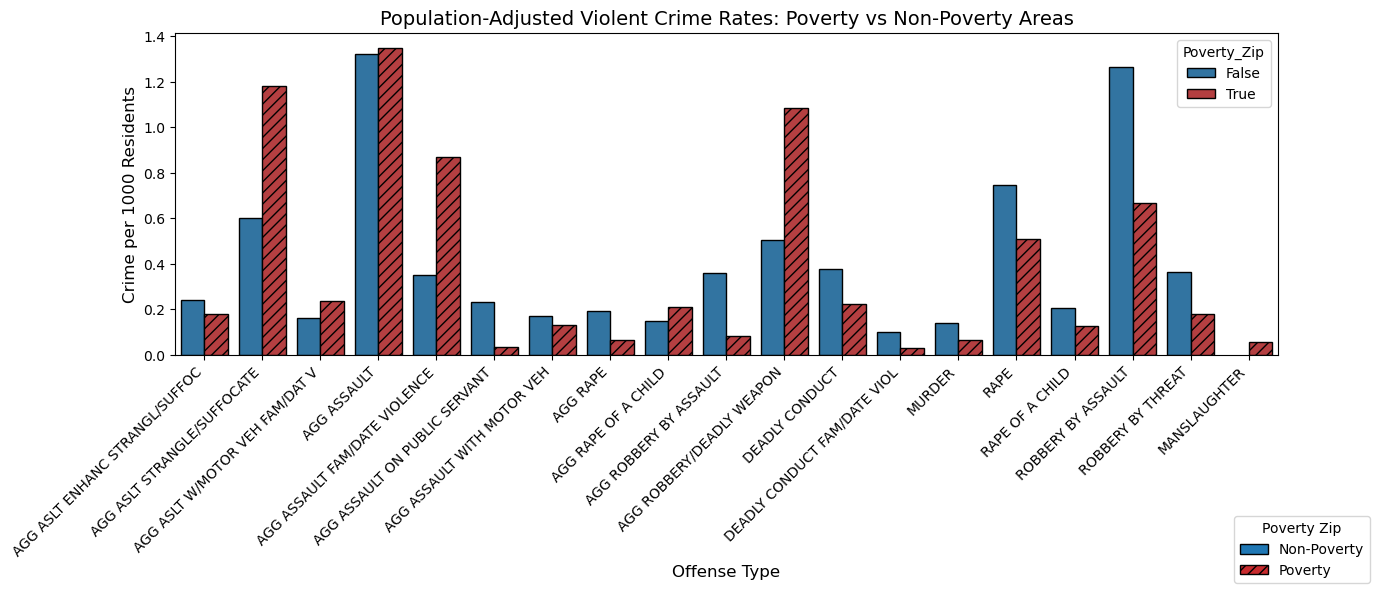

Crime crime rate per 1,000 people:
Poverty_Zip
False    0.415966
True     0.382972
Name: Rate, dtype: float64

Total number of crimes:
Poverty_Zip
False    1053
True     2249
Name: Count, dtype: int64

Number of unique zip codes in each category:
Poverty_Zip
False    31
True     13
Name: Zip_Code_Crime, dtype: int64


In [202]:
# Use the function
population_adjusted(just_v_crime, population_data, 'Highest_Offense_Desc', 'Poverty_Zip', 'Zip_Code_Crime', save_plot=True)

In [203]:
def check_normality(data, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    sns.histplot(data, kde=True, ax=ax1)
    ax1.set_title(f'Histogram of {title}')

    qqplot(data, line='s', ax=ax2)
    ax2.set_title(f'Q-Q Plot of {title}')
    
    plt.tight_layout()
    plt.show()

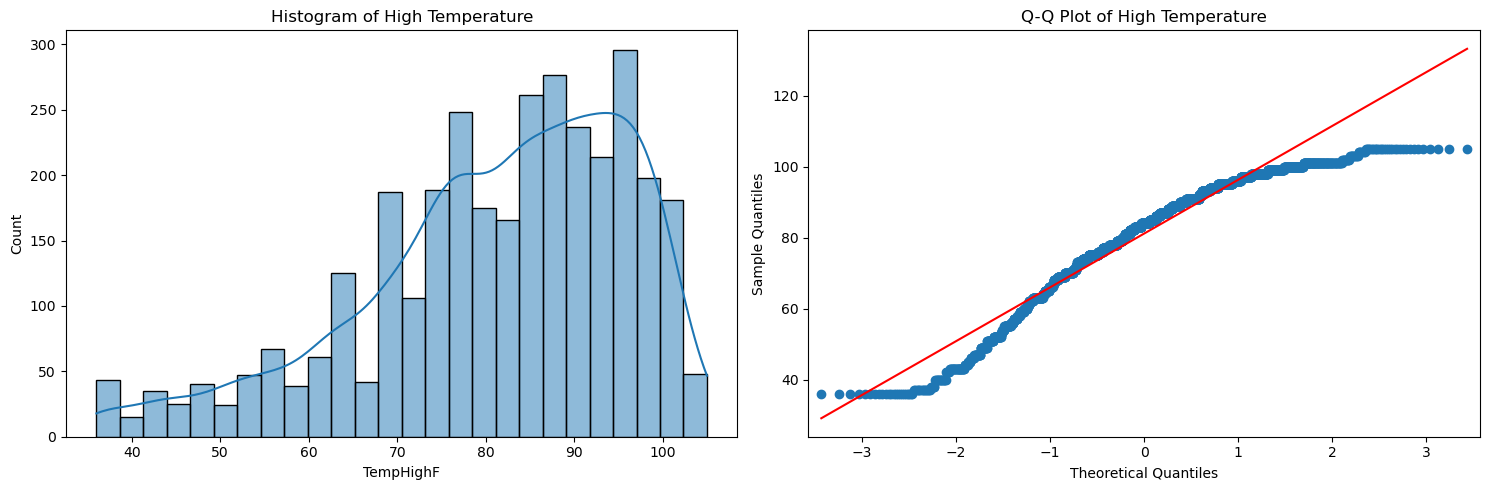

In [204]:
check_normality(just_v_crime['TempHighF'], 'High Temperature')

In [205]:
# Prepare data for checking normality of crime rates
pop_df = population_data.set_index('Zip Code')
pop_df['Population'] = pd.to_numeric(pop_df['Population'].astype(str).str.replace(',', ''), errors='coerce')

# Merge crime data with population data
merged_data = just_v_crime.merge(pop_df[['Population']], left_on='Zip_Code_Crime', right_index=True, how='left')

# Create high temp and low temp groups
merged_data['High_Temp'] = merged_data['TempHighF'] >= 90

rates = merged_data.groupby(['Zip_Code_Crime', 'High_Temp', 'TempHighF']).size().reset_index(name='Count')
rates = rates.merge(merged_data[['Zip_Code_Crime', 'Population']].drop_duplicates(), on='Zip_Code_Crime')
rates['Rate'] = rates['Count'] / rates['Population'] * 1000

original_count = len(rates)
rates = rates.dropna()
dropped_count = original_count - len(rates)

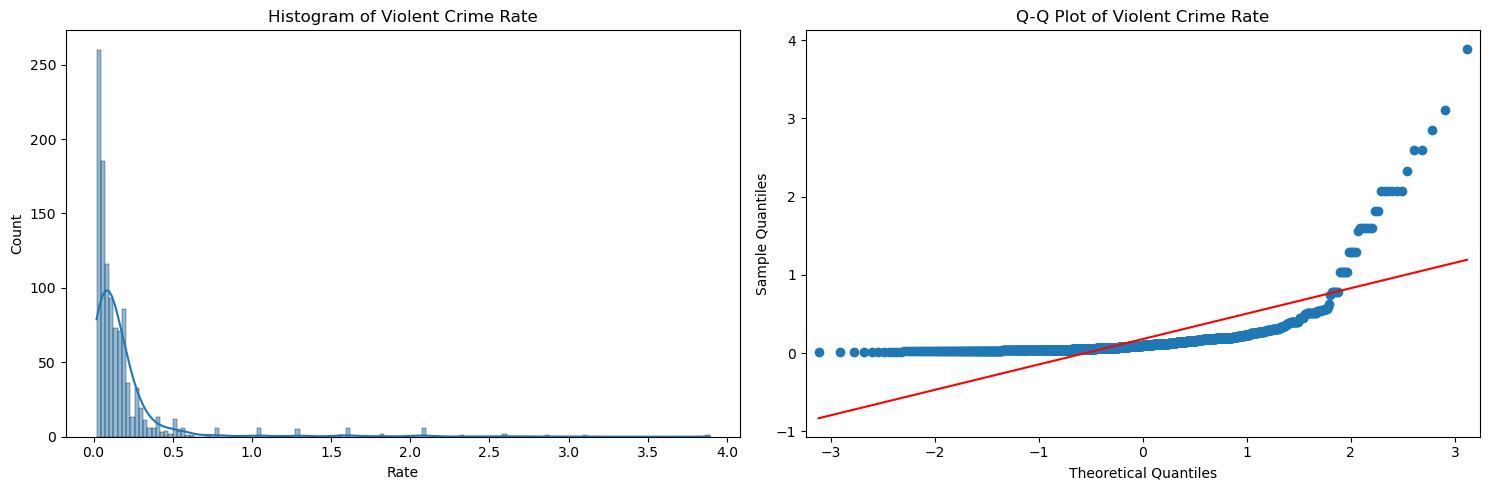

In [206]:
# Check normality of violent crime rates
check_normality(rates['Rate'], 'Violent Crime Rate')

In [207]:
def temperature_effect(crime_data, population_data, temp_threshold=90, save_plot=False, path='plots/violent_crime_rate_vs_temperature.png'):
    # Prepare population data
    pop_df = population_data.set_index('Zip Code')
    pop_df['Population'] = pd.to_numeric(pop_df['Population'].astype(str).str.replace(',', ''), errors='coerce')
    
    # Merge crime data with population data
    merged_data = crime_data.merge(pop_df[['Population']], left_on='Zip_Code_Crime', right_index=True, how='left')
    
    # Create high temp and low temp groups
    merged_data['High_Temp'] = merged_data['TempHighF'] >= temp_threshold
    
    daily_rates = merged_data.groupby(['Zip_Code_Crime', 'High_Temp', 'TempHighF']).size().reset_index(name='Count')
    daily_rates = daily_rates.merge(merged_data[['Zip_Code_Crime', 'Population']].drop_duplicates(), on='Zip_Code_Crime')
    daily_rates['Rate'] = daily_rates['Count'] / daily_rates['Population'] * 1000
    
    # Drop NaN values
    original_count = len(daily_rates)
    daily_rates = daily_rates.dropna()
    dropped_count = original_count - len(daily_rates)
    print(f"Dropped {dropped_count} rows with NaN values.")
    
    # Separate high temp and low temp rates
    high_temp_rates = daily_rates[daily_rates['High_Temp']]['Rate']
    low_temp_rates = daily_rates[~daily_rates['High_Temp']]['Rate']
    
    # Print diagnostic information
    print(f"Number of high temperature days: {len(high_temp_rates)}")
    print(f"Number of low temperature days: {len(low_temp_rates)}")
    print(f"Range of high temperature rates: {high_temp_rates.min()} to {high_temp_rates.max()}")
    print(f"Range of low temperature rates: {low_temp_rates.min()} to {low_temp_rates.max()}")
    
    # Pearson correlation
    corr, p_value= stats.pearsonr(daily_rates['TempHighF'], daily_rates['Rate'])
    print(f"\nPearson correlation between temperature and crime rate: {corr:.4f} (p-value: {p_value:.4f})")
    
    # Perform Mann-Whitney U test
    statistic, p_value = stats.mannwhitneyu(high_temp_rates, low_temp_rates, alternative='two-sided')
    
    # Print results
    print(f"\nTemperature threshold: {temp_threshold}°F")
    print("Mann-Whitney U statistic:", statistic)
    print("p-value:", p_value)
    
    # Interpret the result
    alpha = 0.05  # Significance level
    if p_value <= alpha:
        print(f"\nThe difference in violent crime rates between high temperature (>={temp_threshold}°F) and low temperature (<{temp_threshold}°F) days is statistically significant (p <= {alpha}).")
    else:
        print(f"\nThere is not enough evidence to conclude a significant difference in violent crime rates between high temperature (>={temp_threshold}°F) and low temperature (<{temp_threshold}°F) days (p > {alpha}).")
    
    # Print median rates for comparison (using median instead of mean for non-parametric analysis)
    print("\nMedian violent crime rates per 1000 people:")
    print(f"High temperature days (>={temp_threshold}°F):", high_temp_rates.median())
    print(f"Low temperature days (<{temp_threshold}°F):", low_temp_rates.median())
    
    # Calculate and print the effect size (rank-biserial correlation)
    n1, n2 = len(high_temp_rates), len(low_temp_rates)
    effect_size = 1 - (2 * statistic) / (n1 * n2)
    print(f"\nEffect size (rank-biserial correlation): {effect_size:.4f}")
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='TempHighF', y='Rate', data=daily_rates)
    plt.title('Violent Crime Rate vs. Temperature')
    plt.xlabel('Temperature (°F)')
    plt.ylabel('Violent Crime Rate per 1,000 People')
    plt.axvline(x=temp_threshold, color='r', linestyle='--', label=f'{temp_threshold}°F Threshold')
    plt.legend()
    
    if save_plot:
        plt.savefig(path)
    plt.show()

Dropped 41 rows with NaN values.
Number of high temperature days: 325
Number of low temperature days: 768
Range of high temperature rates: 0.018852273584194255 to 3.8910505836575875
Range of low temperature rates: 0.018852273584194255 to 2.8534370946822305

Pearson correlation between temperature and crime rate: 0.1637 (p-value: 0.0000)

Temperature threshold: 90°F
Mann-Whitney U statistic: 144286.0
p-value: 4.407025628934404e-05

The difference in violent crime rates between high temperature (>=90°F) and low temperature (<90°F) days is statistically significant (p <= 0.05).

Median violent crime rates per 1000 people:
High temperature days (>=90°F): 0.12272950417280314
Low temperature days (<90°F): 0.08875477056891808

Effect size (rank-biserial correlation): -0.1561


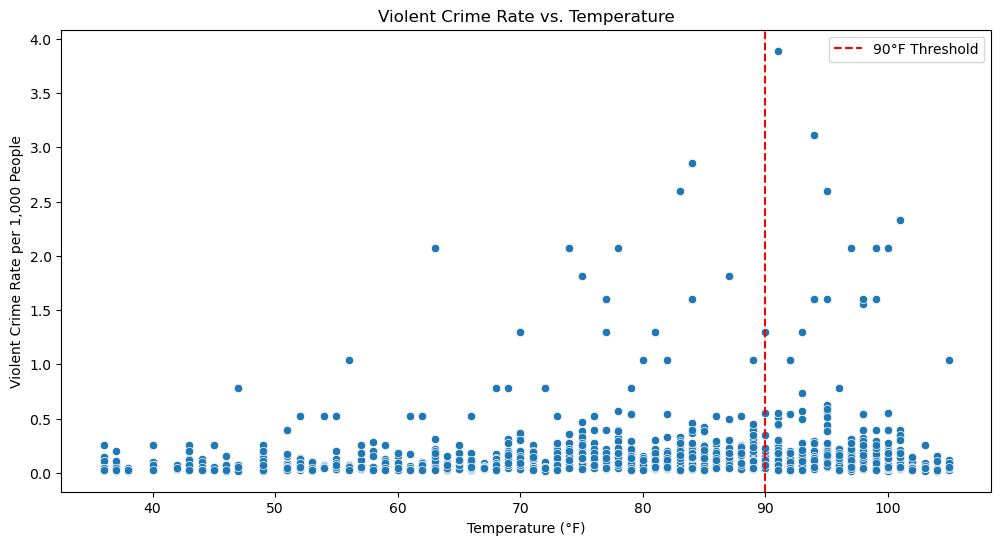

In [208]:
temperature_effect(just_v_crime, population_data, temp_threshold=90, save_plot=True)

In [209]:
def temperature_poverty_effect(crime_data, population_data, poverty_zips, temp_threshold=90, save_plot=False, path='plots/temperature_poverty_effect.png'):
    # Prepare population data
    pop_df = population_data.set_index('Zip Code')
    pop_df['Population'] = pd.to_numeric(pop_df['Population'].astype(str).str.replace(',', ''), errors='coerce')
    
    # Merge crime data with population data
    merged_data = crime_data.merge(pop_df[['Population']], left_on='Zip_Code_Crime', right_index=True, how='left')
    
    # Create high temp and poverty flags
    merged_data['High_Temp'] = merged_data['TempHighF'] >= temp_threshold
    merged_data['Poverty_Zip'] = merged_data['Zip_Code_Crime'].isin(poverty_zips)
    
    daily_rates = merged_data.groupby(['Zip_Code_Crime', 'High_Temp', 'Poverty_Zip', 'TempHighF']).size().reset_index(name='Count')
    daily_rates = daily_rates.merge(merged_data[['Zip_Code_Crime', 'Population']].drop_duplicates(), on='Zip_Code_Crime')
    daily_rates['Rate'] = daily_rates['Count'] / daily_rates['Population'] * 1000
    
    # Drop NaN values
    original_count = len(daily_rates)
    daily_rates = daily_rates.dropna()
    dropped_count = original_count - len(daily_rates)
    print(f"Dropped {dropped_count} rows with NaN values.")
    
    high_temp_poverty = daily_rates[(daily_rates['High_Temp']) & (daily_rates['Poverty_Zip'])]['Rate']
    low_temp_poverty = daily_rates[(~daily_rates['High_Temp']) & (daily_rates['Poverty_Zip'])]['Rate']
    high_temp_non_poverty = daily_rates[(daily_rates['High_Temp']) & (~daily_rates['Poverty_Zip'])]['Rate']
    low_temp_non_poverty = daily_rates[(~daily_rates['High_Temp']) & (~daily_rates['Poverty_Zip'])]['Rate']
    
    print(f"\nNumber of high temperature days in poverty areas: {len(high_temp_poverty)}")
    print(f"Number of low temperature days in poverty areas: {len(low_temp_poverty)}")
    print(f"Number of high temperature days in non-poverty areas: {len(high_temp_non_poverty)}")
    print(f"Number of low temperature days in non-poverty areas: {len(low_temp_non_poverty)}")
    
    # Pearson correlation
    poverty_corr, poverty_p = stats.pearsonr(daily_rates[daily_rates['Poverty_Zip']]['TempHighF'], 
                                             daily_rates[daily_rates['Poverty_Zip']]['Rate'])
    non_poverty_corr, non_poverty_p = stats.pearsonr(daily_rates[~daily_rates['Poverty_Zip']]['TempHighF'], 
                                                     daily_rates[~daily_rates['Poverty_Zip']]['Rate'])
    
    print("\nPearson Correlation:")
    print(f"Poverty Areas - Correlation: {poverty_corr:.4f}, p-value: {poverty_p:.4f}")
    print(f"Non-Poverty Areas - Correlation: {non_poverty_corr:.4f}, p-value: {non_poverty_p:.4f}")
    
    # Perform Mann-Whitney U tests
    poverty_statistic, poverty_p_value = stats.mannwhitneyu(high_temp_poverty, low_temp_poverty, alternative='two-sided')
    non_poverty_statistic, non_poverty_p_value = stats.mannwhitneyu(high_temp_non_poverty, low_temp_non_poverty, alternative='two-sided')
    
    # Print results
    print(f"\nTemperature threshold: {temp_threshold}°F")
    print("\nPoverty Areas:")
    print("Mann-Whitney U statistic:", poverty_statistic)
    print("p-value:", poverty_p_value)
    print("\nNon-Poverty Areas:")
    print("Mann-Whitney U statistic:", non_poverty_statistic)
    print("p-value:", non_poverty_p_value)
    
    # Interpret the results
    alpha = 0.05  # Significance level
    for area_type, p_value in [("Poverty", poverty_p_value), ("Non-Poverty", non_poverty_p_value)]:
        if p_value <= alpha:
            print(f"\nThe difference in crime rates between high temperature (>={temp_threshold}°F) and low temperature (<{temp_threshold}°F) days in {area_type} areas is statistically significant (p <= {alpha}).")
        else:
            print(f"\nThere is not enough evidence to conclude a significant difference in crime rates between high temperature (>={temp_threshold}°F) and low temperature (<{temp_threshold}°F) days in {area_type} areas (p > {alpha}).")
    
    # Print median rates for comparison
    print("\nMedian violent crime rates per 1000 people:")
    print("Poverty Areas:")
    print(f"High temperature days (>={temp_threshold}°F):", high_temp_poverty.median())
    print(f"Low temperature days (<{temp_threshold}°F):", low_temp_poverty.median())
    print("Non-Poverty Areas:")
    print(f"High temperature days (>={temp_threshold}°F):", high_temp_non_poverty.median())
    print(f"Low temperature days (<{temp_threshold}°F):", low_temp_non_poverty.median())
    
    # Calculate and print the effect sizes (rank-biserial correlation)
    poverty_effect_size = 1 - (2 * poverty_statistic) / (len(high_temp_poverty) * len(low_temp_poverty))
    non_poverty_effect_size = 1 - (2 * non_poverty_statistic) / (len(high_temp_non_poverty) * len(low_temp_non_poverty))
    print(f"\nEffect size (rank-biserial correlation) for Poverty Areas: {poverty_effect_size:.4f}")
    print(f"Effect size (rank-biserial correlation) for Non-Poverty Areas: {non_poverty_effect_size:.4f}")
    
    # Add summary statistics
    print("\nSummary Statistics:")
    for group in ['Poverty', 'Non-Poverty']:
        for temp in ['High', 'Low']:
            data = daily_rates[
                (daily_rates['Poverty_Zip'] if group == 'Poverty' else ~daily_rates['Poverty_Zip']) &
                (daily_rates['High_Temp'] if temp == 'High' else ~daily_rates['High_Temp'])
            ]['Rate']
            print(f"\n{group} Areas, {temp} Temperature:")
            print(f"Mean: {data.mean():.6f}")
            print(f"Median: {data.median():.6f}")
            print(f"Std Dev: {data.std():.6f}")
            print(f"Min: {data.min():.6f}")
            print(f"Max: {data.max():.6f}")
            
    # Scatterplots
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=daily_rates[daily_rates['Poverty_Zip']], x='TempHighF', y='Rate')
    plt.title('Poverty Areas: Temperature vs Crime Rate')
    plt.xlabel('Temperature (°F)')
    plt.ylabel('Crime Rate per 1,000 people')
    plt.axvline(x=temp_threshold, color='r', linestyle='--', label=f'{temp_threshold}°F Threshold')
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=daily_rates[~daily_rates['Poverty_Zip']], x='TempHighF', y='Rate')
    plt.title('Non-Poverty Areas: Temperature vs Crime Rate')
    plt.xlabel('Temperature (°F)')
    plt.ylabel('Crime Rate per 1,000 people')
    plt.axvline(x=temp_threshold, color='r', linestyle='--', label=f'{temp_threshold}°F Threshold')
    plt.tight_layout()
    
    if save_plot:
        plt.savefig(path)
    plt.show()

Dropped 41 rows with NaN values.

Number of high temperature days in poverty areas: 166
Number of low temperature days in poverty areas: 438
Number of high temperature days in non-poverty areas: 159
Number of low temperature days in non-poverty areas: 330

Pearson Correlation:
Poverty Areas - Correlation: 0.2942, p-value: 0.0000
Non-Poverty Areas - Correlation: 0.1047, p-value: 0.0206

Temperature threshold: 90°F

Poverty Areas:
Mann-Whitney U statistic: 45621.0
p-value: 1.293692823490021e-06

Non-Poverty Areas:
Mann-Whitney U statistic: 28245.0
p-value: 0.16966215575018762

The difference in crime rates between high temperature (>=90°F) and low temperature (<90°F) days in Poverty areas is statistically significant (p <= 0.05).

There is not enough evidence to conclude a significant difference in crime rates between high temperature (>=90°F) and low temperature (<90°F) days in Non-Poverty areas (p > 0.05).

Median violent crime rates per 1000 people:
Poverty Areas:
High temperature day

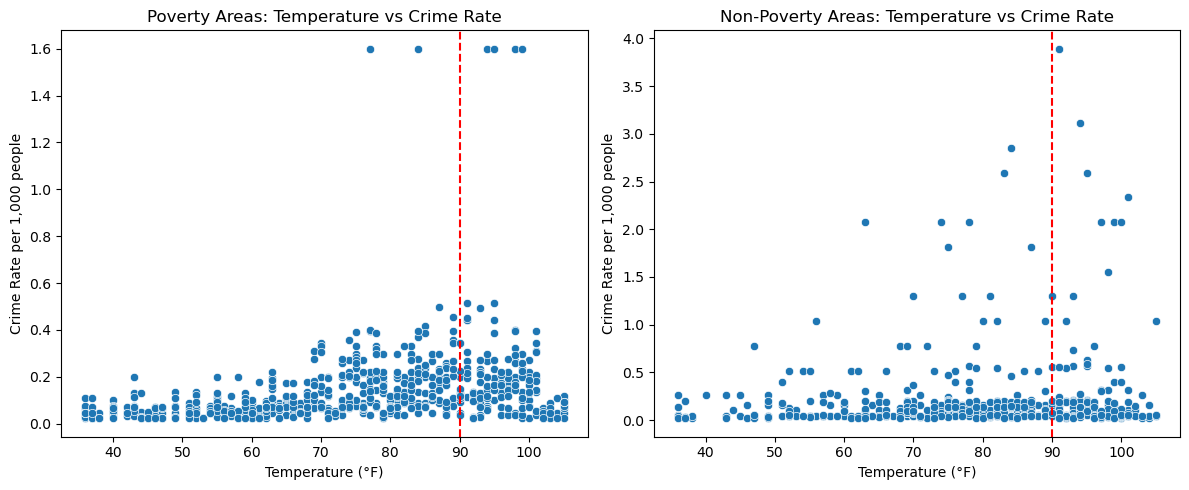

In [210]:
# Examine the effect of temperature on violent crime rates in poverty vs. non-poverty areas
temperature_poverty_effect(just_v_crime, population_data, poverty_zips, temp_threshold=90, save_plot=True, path='plots/temperature_poverty_effect_violent_crime.png')

Dropped 196 rows with NaN values.

Number of high temperature days in poverty areas: 199
Number of low temperature days in poverty areas: 604
Number of high temperature days in non-poverty areas: 354
Number of low temperature days in non-poverty areas: 1012

Pearson Correlation:
Poverty Areas - Correlation: 0.5364, p-value: 0.0000
Non-Poverty Areas - Correlation: 0.1722, p-value: 0.0000

Temperature threshold: 90°F

Poverty Areas:
Mann-Whitney U statistic: 82987.5
p-value: 7.274638625849057e-16

Non-Poverty Areas:
Mann-Whitney U statistic: 223274.0
p-value: 4.8103170228687905e-12

The difference in crime rates between high temperature (>=90°F) and low temperature (<90°F) days in Poverty areas is statistically significant (p <= 0.05).

The difference in crime rates between high temperature (>=90°F) and low temperature (<90°F) days in Non-Poverty areas is statistically significant (p <= 0.05).

Median violent crime rates per 1000 people:
Poverty Areas:
High temperature days (>=90°F): 1.3

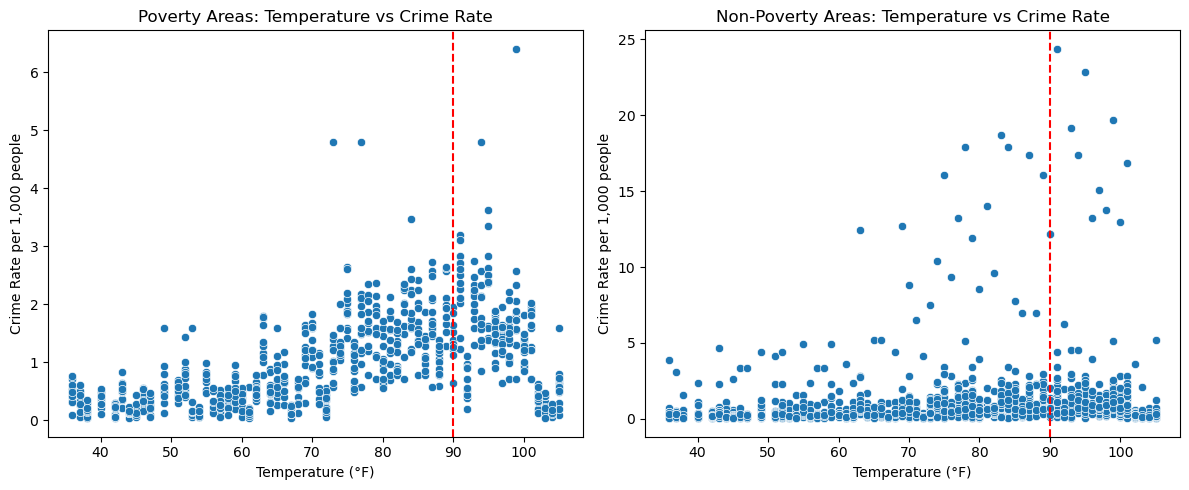

In [211]:
# Examine the effect of temperature on all crime rates in poverty vs. non-poverty areas
temperature_poverty_effect(crime_temp, population_data, poverty_zips, temp_threshold=90, save_plot=True, path='plots/temperature_poverty_effect_all_crime.png')